In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from matplotlib.patches import Rectangle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, f1_score

df_stroke = pd.read_csv('stroke.csv')
sns.set(style='whitegrid')

#Análise Exploratória dos dados

##Informações gerais do dataframe

In [3]:
df_stroke.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [4]:
df_stroke.shape

(5110, 12)

In [5]:
df_stroke.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [6]:
# Valores nulos
df_stroke.isnull().sum()

,0
id,0
gender,0
age,0
hypertension,0
heart_disease,0
ever_married,0
work_type,0
Residence_type,0
avg_glucose_level,0
bmi,201


In [7]:
# Total de valores únicos para cada variável
valores_unicos = []
for coluna in df_stroke.columns[0:12].tolist():
    print(coluna, ":", len(df_stroke[coluna].astype(str).value_counts()))
    valores_unicos.append(len(df_stroke[coluna].astype(str).value_counts()))

id : 5110
gender : 3
age : 104
hypertension : 2
heart_disease : 2
ever_married : 2
work_type : 5
Residence_type : 2
avg_glucose_level : 3979
bmi : 419
smoking_status : 4
stroke : 2


In [8]:
# Estatísticas básicas
df_stroke.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [9]:
# Distribuição dos valores da variável target
df_stroke['stroke'].value_counts()

,count
stroke,
0,4861
1,249


## 1. Perfil de risco e demografia

### Qual a distribuição de idade dos pacientes com AVC?

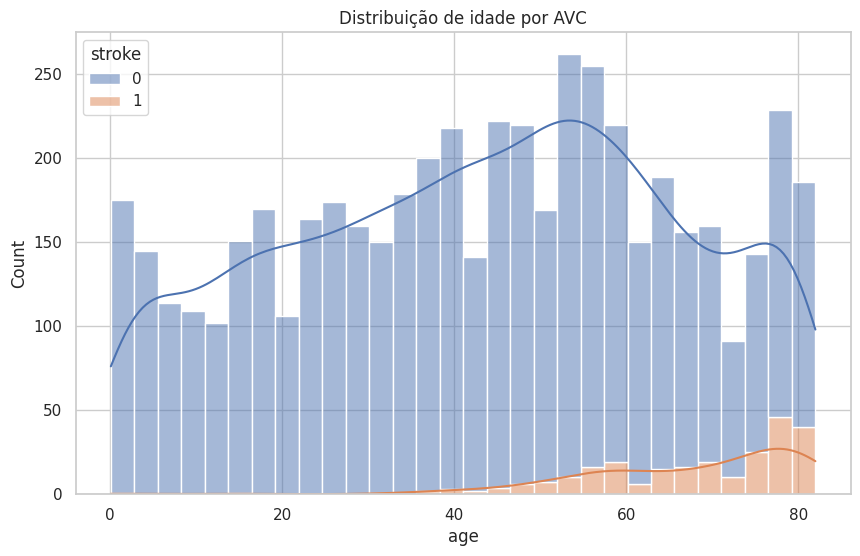

In [10]:

plt.figure(figsize=(10,6))
sns.histplot(data=df_stroke, x="age", hue="stroke", kde=True, bins=30, multiple="stack")
plt.title("Distribuição de idade por AVC")
plt.show()


### Existe uma faixa etária mais vulnerável ao AVC?

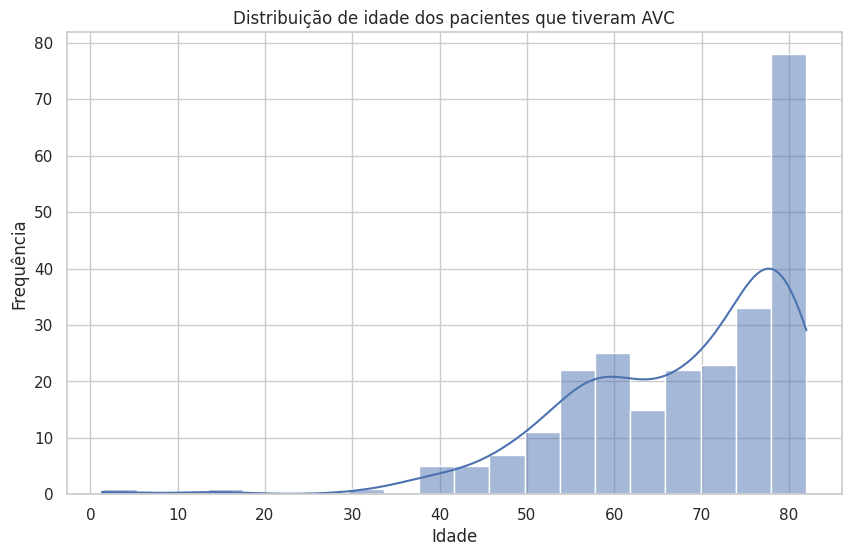

In [11]:
plt.figure(figsize=(10,6))
sns.histplot(data=df_stroke[df_stroke['stroke'] == 1], x='age', bins=20, kde=True)
plt.title("Distribuição de idade dos pacientes que tiveram AVC")
plt.xlabel("Idade")
plt.ylabel("Frequência")
plt.show()


### 🔹 Qual o impacto do gênero no risco de AVC?

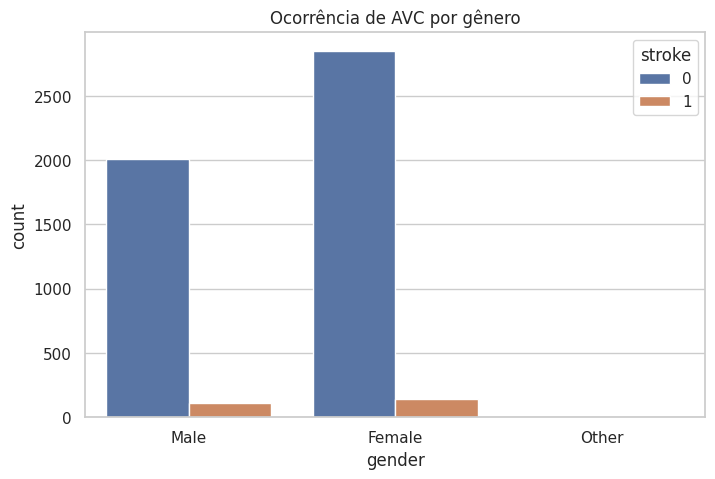

In [12]:

plt.figure(figsize=(8,5))
sns.countplot(data=df_stroke, x="gender", hue="stroke")
plt.title("Ocorrência de AVC por gênero")
plt.show()


### 🔹 Pessoas casadas têm maior ou menor incidência de AVC?

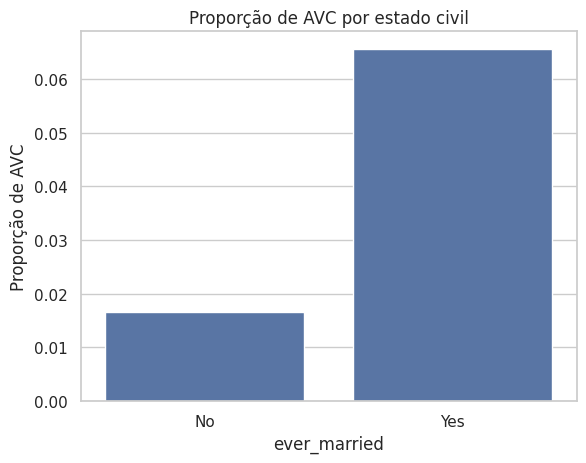

In [13]:
df_married_avc = df_stroke.groupby('ever_married')['stroke'].mean().reset_index()
sns.barplot(data=df_married_avc, x='ever_married', y='stroke')
plt.title("Proporção de AVC por estado civil")
plt.ylabel("Proporção de AVC")
plt.show()


### 🔹 Existe alguma correlação entre estado civil e faixa etária nos casos de AVC?

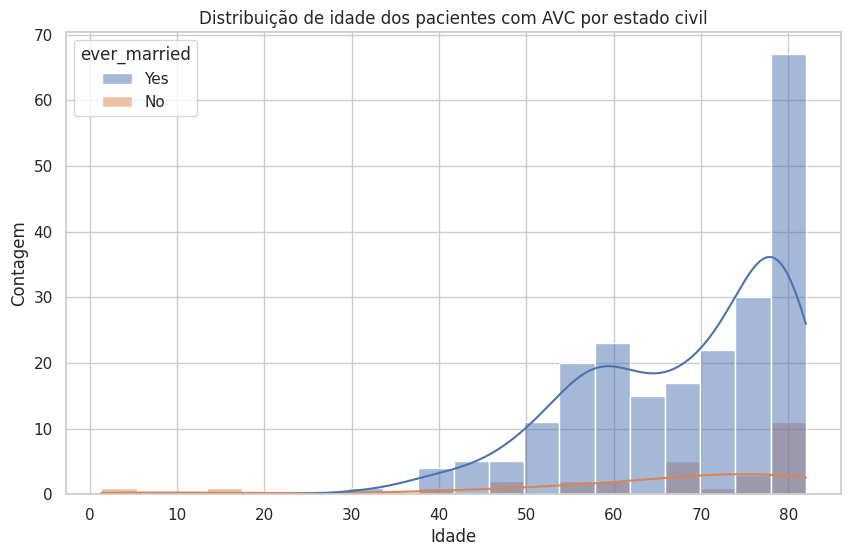

In [14]:

plt.figure(figsize=(10,6))
sns.histplot(data=df_stroke[df_stroke['stroke'] == 1], x='age', hue='ever_married', kde=True, bins=20)
plt.title("Distribuição de idade dos pacientes com AVC por estado civil")
plt.xlabel("Idade")
plt.ylabel("Contagem")
plt.show()

### 🔹 Qual a idade média de quem teve AVC entre casados vs não casados?

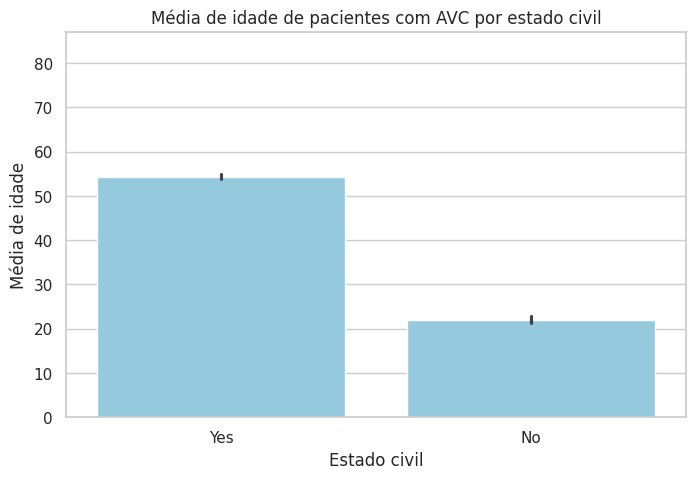

In [15]:
plt.figure(figsize=(8,5))
sns.barplot(data=df_stroke, x='ever_married', y='age', color='skyblue')  # type: ignore # define cor única
plt.title("Média de idade de pacientes com AVC por estado civil")
plt.ylabel("Média de idade")
plt.xlabel("Estado civil")
plt.ylim(0, df_stroke['age'].max() + 5) # type: ignore
plt.show()


### 🔹 A taxa de AVC entre casados continua alta mesmo controlando por idade?

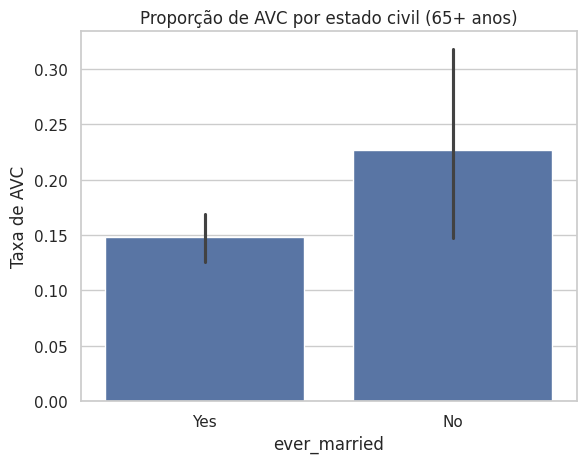

In [16]:
df_50plus = df_stroke[df_stroke['age'] >= 65]
sns.barplot(data=df_50plus, x='ever_married', y='stroke')
plt.title("Proporção de AVC por estado civil (65+ anos)")
plt.ylabel("Taxa de AVC")
plt.show()


### 🔹 A idade média dos casados é maior do que dos não casados?

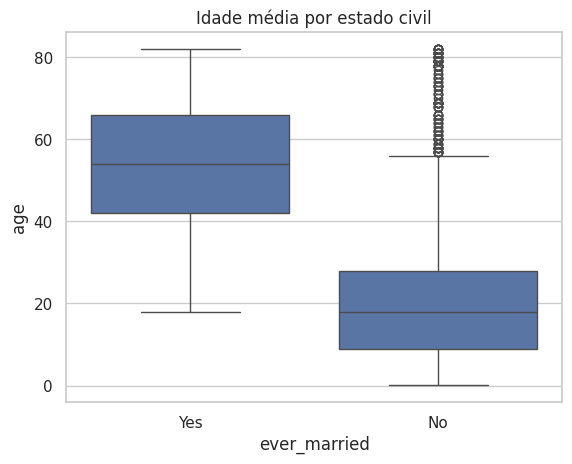

In [17]:
sns.boxplot(data=df_stroke, x='ever_married', y='age')
plt.title("Idade média por estado civil")
plt.show()


### Há mais homens ou mulheres entre os casados que tiveram AVC?

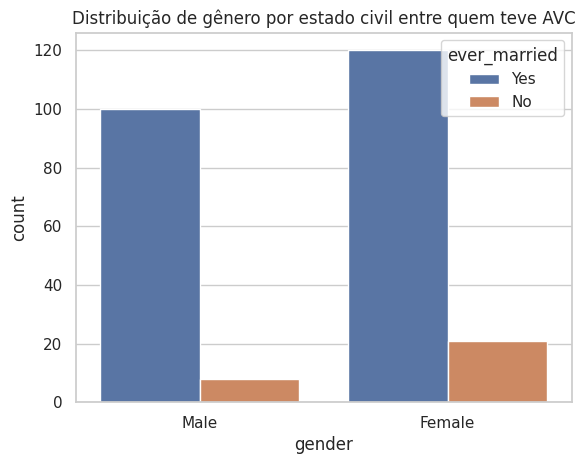

In [18]:
sns.countplot(data=df_stroke[df_stroke['stroke'] == 1], x='gender', hue='ever_married')
plt.title("Distribuição de gênero por estado civil entre quem teve AVC")
plt.show()


### 🔹Estado civil e IMC: obesidade influencia na taxa entre casados?

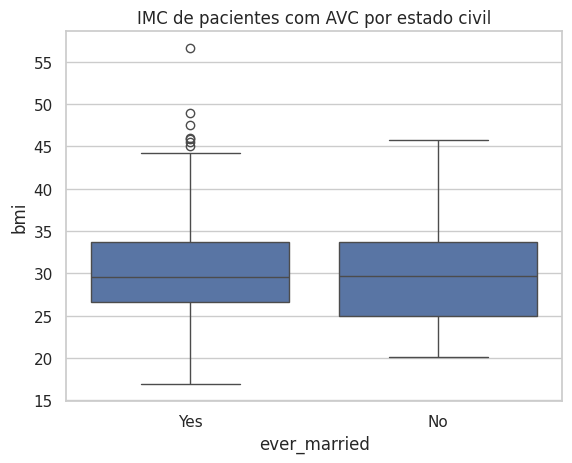

In [19]:
sns.boxplot(data=df_stroke[df_stroke['stroke'] == 1], x='ever_married', y='bmi')
plt.title("IMC de pacientes com AVC por estado civil")
plt.show()


## 2. Fatores clínicos

### 🔹 Qual a incidência de AVC entre hipertensos?

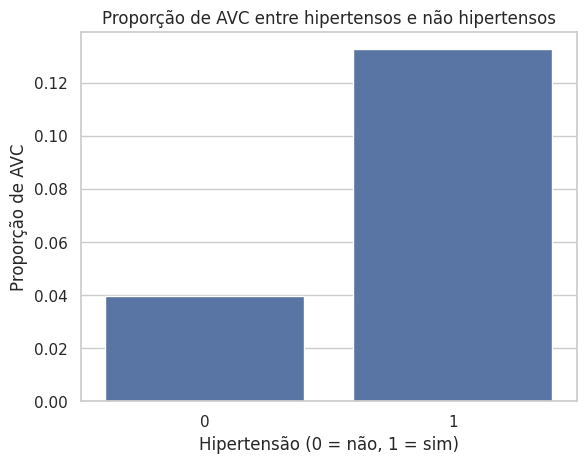

In [20]:
df_hyper = df_stroke.groupby('hypertension')['stroke'].mean().reset_index()
sns.barplot(data=df_hyper, x='hypertension', y='stroke')
plt.title("Proporção de AVC entre hipertensos e não hipertensos")
plt.ylabel("Proporção de AVC")
plt.xlabel("Hipertensão (0 = não, 1 = sim)")
plt.show()


### 🔹 Pacientes com doença cardíaca têm maior probabilidade de AVC?

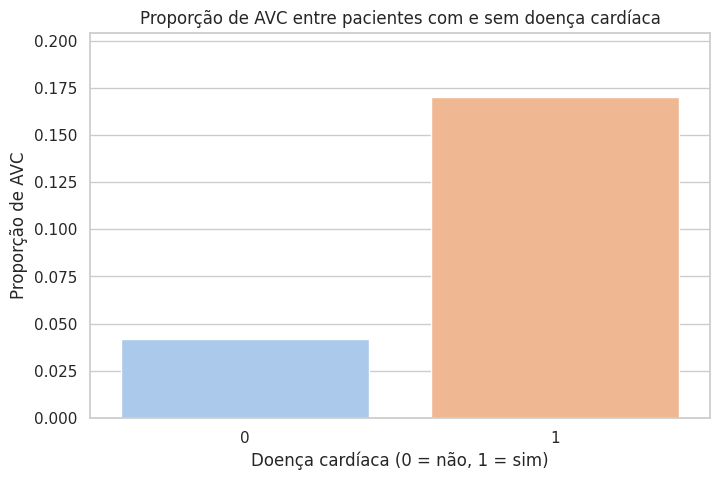

In [21]:
# Agrupando por presença de doença cardíaca e calculando proporção de AVC
df_heart = df_stroke.groupby('heart_disease')['stroke'].mean().reset_index()

plt.figure(figsize=(8,5))
sns.barplot(data=df_heart, x='heart_disease', y='stroke', hue='heart_disease', palette='pastel', legend=False)
plt.title("Proporção de AVC entre pacientes com e sem doença cardíaca")
plt.xlabel("Doença cardíaca (0 = não, 1 = sim)")
plt.ylabel("Proporção de AVC")
plt.ylim(0, df_heart['stroke'].max()*1.2)
plt.show()

### 🔹 Existe correlação entre hipertensão e doença cardíaca no grupo com AVC?

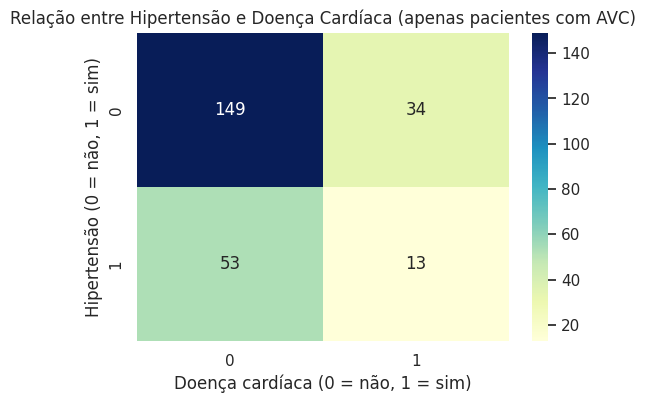

In [22]:
# Filtrar apenas quem teve AVC
df_occr_stroke = df_stroke[df_stroke['stroke'] == 1]

# Tabela cruzada
cross_tab = pd.crosstab(df_occr_stroke['hypertension'], df_occr_stroke['heart_disease'])

# Heatmap da relação
plt.figure(figsize=(6,4))
sns.heatmap(cross_tab, annot=True, cmap="YlGnBu", fmt="d")
plt.title("Relação entre Hipertensão e Doença Cardíaca (apenas pacientes com AVC)")
plt.xlabel("Doença cardíaca (0 = não, 1 = sim)")
plt.ylabel("Hipertensão (0 = não, 1 = sim)")
plt.show()



### 🔹 Qual é o nível médio de glicose nos pacientes que tiveram AVC?

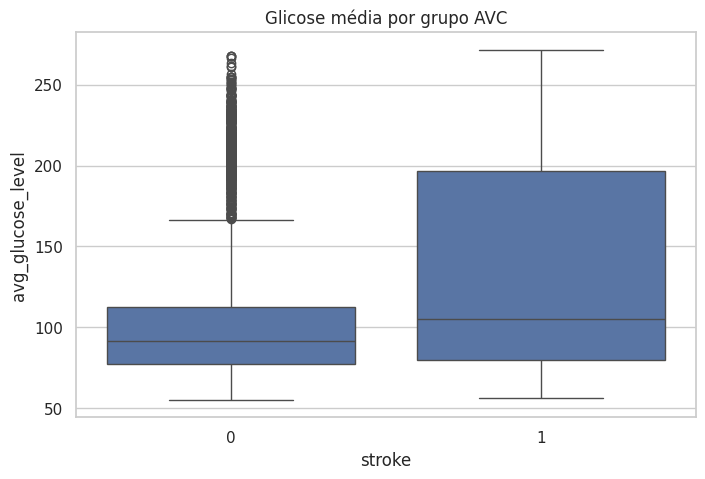

In [23]:

plt.figure(figsize=(8,5))
sns.boxplot(data=df_stroke, x="stroke", y="avg_glucose_level")
plt.title("Glicose média por grupo AVC")
plt.show()


### 🔹 Qual o IMC médio entre pacientes que sofreram AVC?

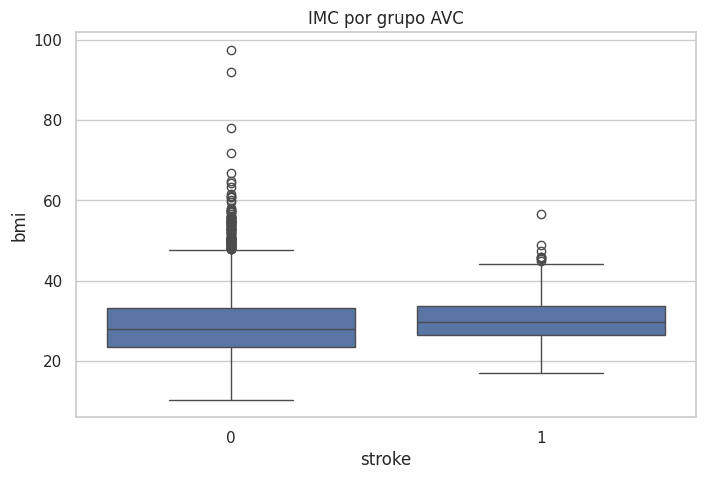

In [24]:

plt.figure(figsize=(8,5))
sns.boxplot(data=df_stroke, x="stroke", y="bmi")
plt.title("IMC por grupo AVC")
plt.show()


### 🔹 Obesidade (IMC alto) aumenta o risco de AVC no conjunto de dados?

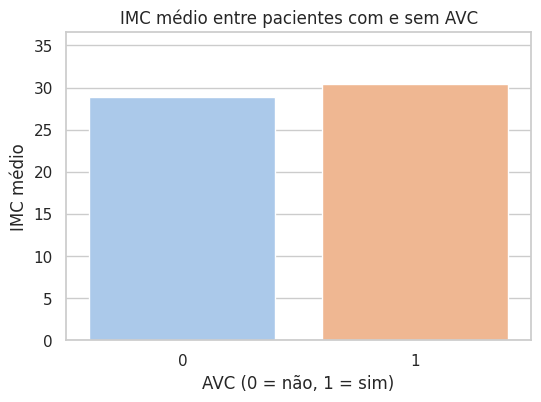

In [25]:
df_bmi = df_stroke.groupby('stroke')['bmi'].mean().reset_index()

plt.figure(figsize=(6,4))
sns.barplot(data=df_bmi, x='stroke', y='bmi', hue='stroke', palette='pastel', legend=False)
plt.title("IMC médio entre pacientes com e sem AVC")
plt.xlabel("AVC (0 = não, 1 = sim)")
plt.ylabel("IMC médio")
plt.ylim(0, df_bmi['bmi'].max()*1.2)
plt.show()

## 3. Estilo de vida e hábitos

### 🔹 Fumantes têm maior incidência de AVC?

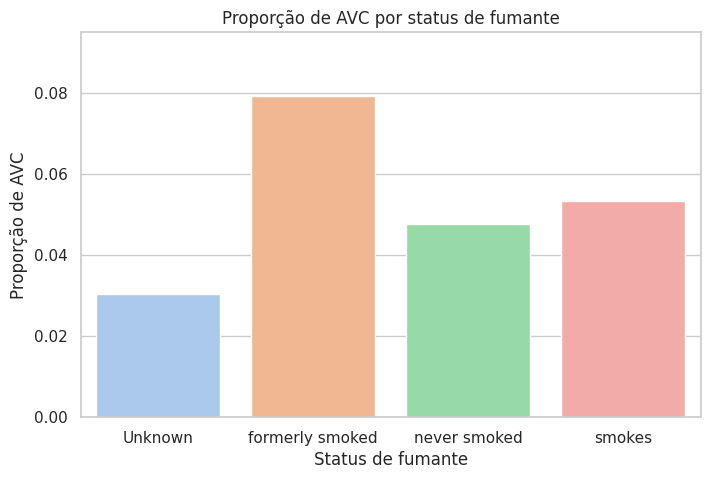

In [26]:
# Proporção de AVC por grupo de fumante
df_smoke = df_stroke.groupby('smoking_status')['stroke'].mean().reset_index()

# Gráfico
plt.figure(figsize=(8,5))
sns.barplot(data=df_smoke, x='smoking_status', y='stroke', hue='smoking_status', palette='pastel', legend=False)
plt.title("Proporção de AVC por status de fumante")
plt.xlabel("Status de fumante")
plt.ylabel("Proporção de AVC")
plt.ylim(0, df_smoke['stroke'].max()*1.2)
plt.show()




### 🔹 Qual o risco relativo entre fumantes, ex-fumantes e não fumantes?

stroke,proporcao_avc,risco_relativo
smoking_status,,
never smoked,0.047569,1.000000
formerly smoked,0.079096,1.662775
smokes,0.053232,1.119054


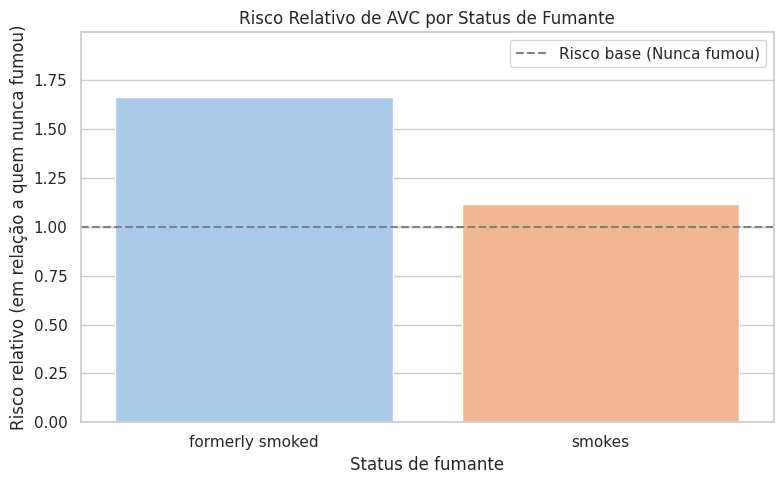

In [27]:
# Criar tabela de contingência: fumantes vs AVC
contingencia = df_stroke.groupby(['smoking_status', 'stroke']).size().unstack(fill_value=0)
contingencia = contingencia.reindex(['never smoked', 'formerly smoked', 'smokes'])  # ordem lógica

# Calcular proporção de AVC
contingencia['proporcao_avc'] = contingencia[1] / (contingencia[0] + contingencia[1])

# Calcular risco relativo em relação ao grupo "never smoked"
baseline = contingencia.loc['never smoked', 'proporcao_avc']
contingencia['risco_relativo'] = contingencia['proporcao_avc'] / baseline

# Exibir a tabela com proporção e risco relativo
display(contingencia[['proporcao_avc', 'risco_relativo']])

# Preparar dados para o gráfico
df_rr = contingencia[['risco_relativo']].reset_index()
df_rr = df_rr[df_rr['smoking_status'].isin(['formerly smoked', 'smokes'])]  # tirar baseline

# Plotar gráfico
plt.figure(figsize=(8,5))
sns.barplot(data=df_rr, x='smoking_status', y='risco_relativo', hue='smoking_status', palette='pastel', legend=False)
plt.axhline(1, color='gray', linestyle='--', label='Risco base (Nunca fumou)')
plt.title("Risco Relativo de AVC por Status de Fumante")
plt.xlabel("Status de fumante")
plt.ylabel("Risco relativo (em relação a quem nunca fumou)")
plt.ylim(0, df_rr['risco_relativo'].max() * 1.2)
plt.legend()
plt.tight_layout()
plt.show()

### 🔹 O status de fumante combinado com hipertensão aumenta o risco?

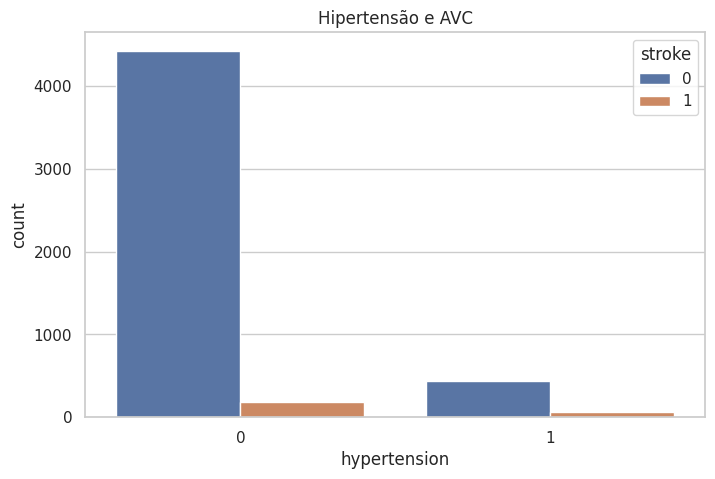

In [28]:

plt.figure(figsize=(8,5))
sns.countplot(data=df_stroke, x="hypertension", hue="stroke")
plt.title("Hipertensão e AVC")
plt.show()


### 🔹 Há alguma relação entre tipo de residência (urbana/rural) e ocorrência de AVC?

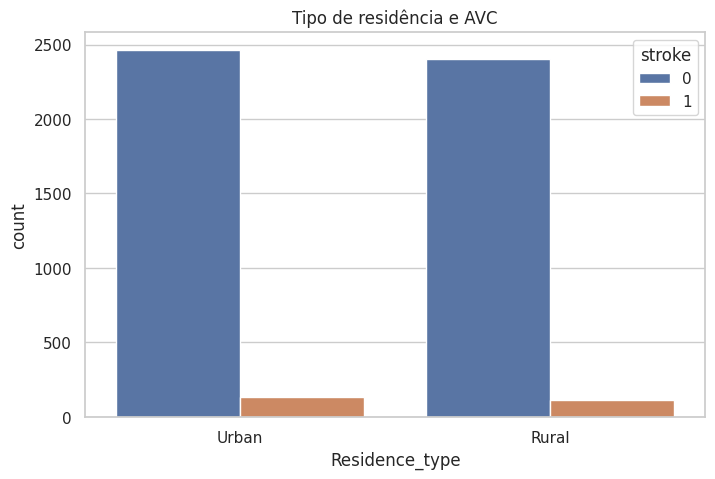

In [29]:

plt.figure(figsize=(8,5))
sns.countplot(data=df_stroke, x="Residence_type", hue="stroke")
plt.title("Tipo de residência e AVC")
plt.show()


## 4. Profissão e condição socioeconômica

### 🔹 Qual tipo de trabalho mais aparece nos casos de AVC?

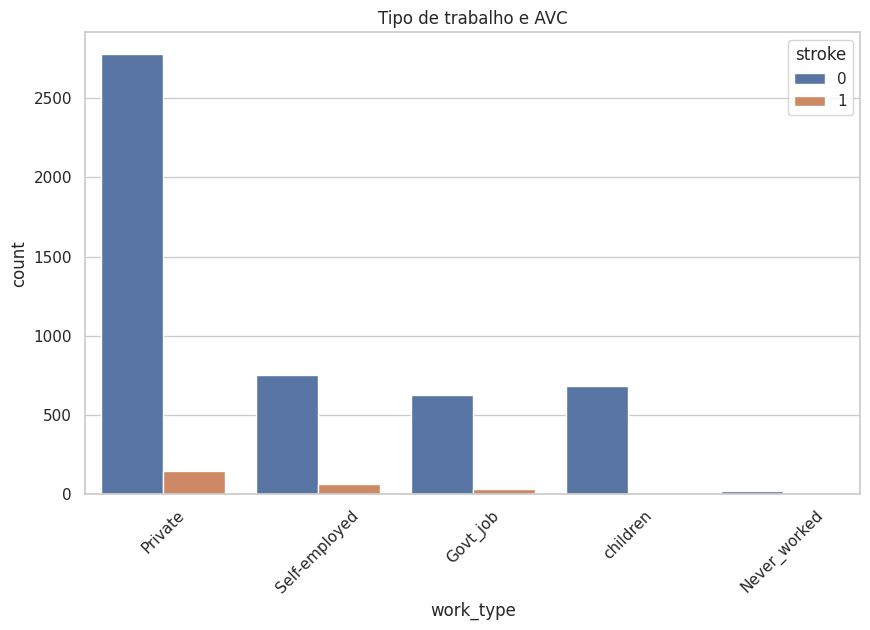

In [30]:

plt.figure(figsize=(10,6))
sns.countplot(data=df_stroke, x="work_type", hue="stroke")
plt.title("Tipo de trabalho e AVC")
plt.xticks(rotation=45)
plt.show()


### 🔹 O risco de AVC varia entre quem trabalha no setor privado, público ou autônomo?

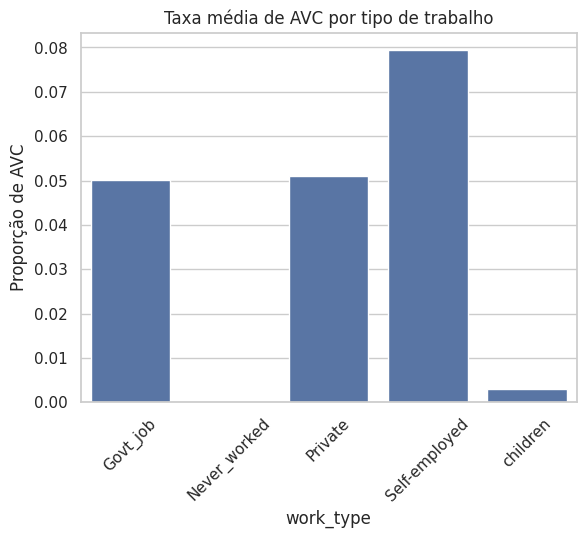

In [31]:
df_work_avc = df_stroke.groupby('work_type')['stroke'].mean().reset_index()
sns.barplot(data=df_work_avc, x='work_type', y='stroke')
plt.title("Taxa média de AVC por tipo de trabalho")
plt.ylabel("Proporção de AVC")
plt.xticks(rotation=45)
plt.show()


### 🔹 A taxa de AVC em aposentados ou desempregados é maior?

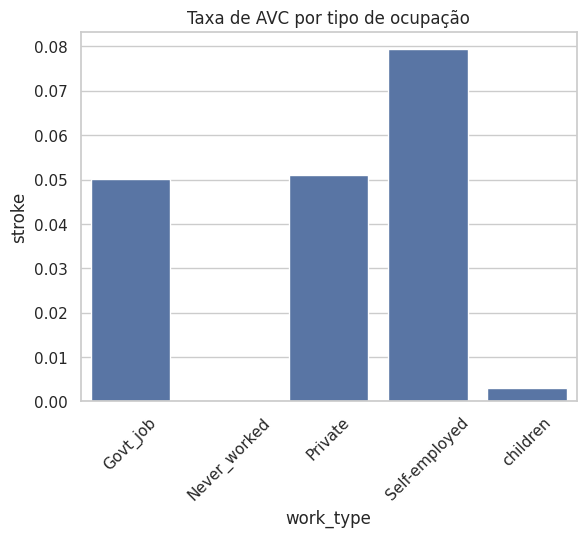

In [32]:
df_filter = df_stroke[df_stroke['work_type'].isin(['Self-employed', 'Private', 'children', 'Govt_job', 'Never_worked'])]
df_grouped = df_filter.groupby('work_type')['stroke'].mean().reset_index()
sns.barplot(data=df_grouped, x='work_type', y='stroke')
plt.title("Taxa de AVC por tipo de ocupação")
plt.xticks(rotation=45)
plt.show()


## 5. Correlações estatísticas

### 🔹 Quais variáveis mais se correlacionam com a ocorrência de AVC?

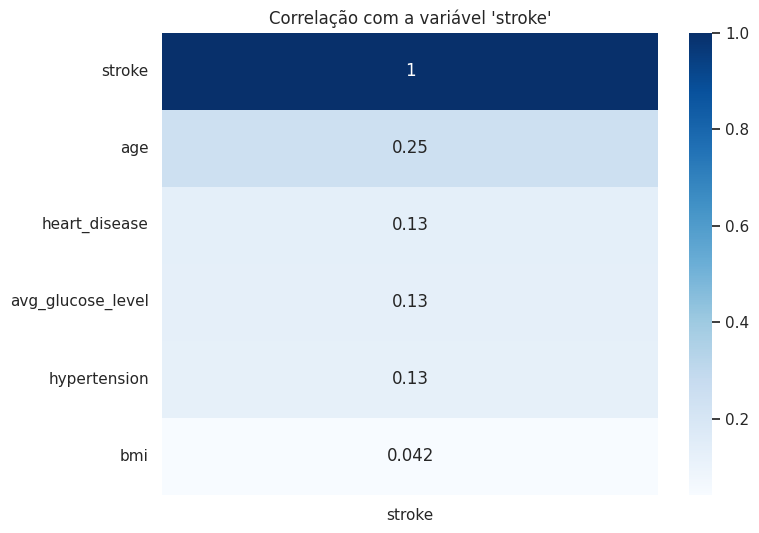

In [33]:
plt.figure(figsize=(8,6))
corr = df_stroke[['age', 'avg_glucose_level', 'bmi', 'hypertension', 'heart_disease', 'stroke']].corr()
sns.heatmap(corr[['stroke']].sort_values(by='stroke', ascending=False), annot=True, cmap='Blues')
plt.title("Correlação com a variável 'stroke'")
plt.show()


### 🔹 Existe correlação entre IMC e idade?

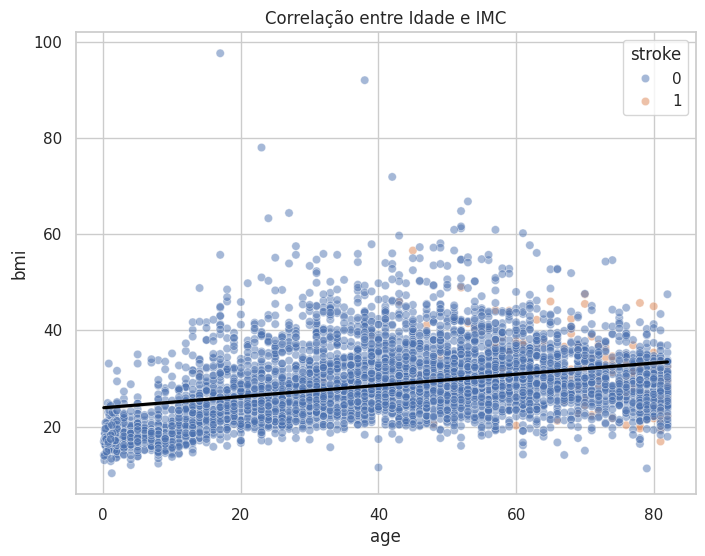

In [34]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=df_stroke, x='age', y='bmi', hue='stroke', alpha=0.5)
sns.regplot(data=df_stroke, x='age', y='bmi', scatter=False, color='black')
plt.title("Correlação entre Idade e IMC")
plt.show()



### 🔹 Qual é a correlação entre glicemia média e AVC?

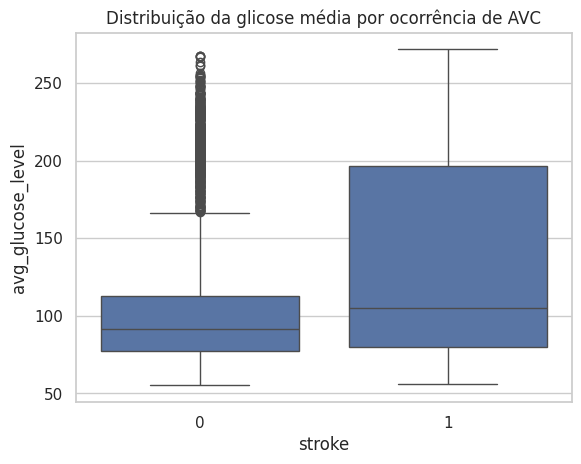

In [35]:
sns.boxplot(x='stroke', y='avg_glucose_level', data=df_stroke)
plt.title("Distribuição da glicose média por ocorrência de AVC")
plt.show()


## 6. Desequilíbrio de classes e proporções

### 🔹 Qual o percentual de pacientes com AVC no dataset?

In [36]:

print("Percentual de pacientes com AVC:", (df_stroke['stroke'].mean() * 100).round(2), "%")


Percentual de pacientes com AVC: 4.87 %


### 🔹 O dataset está balanceado entre casos positivos e negativos?

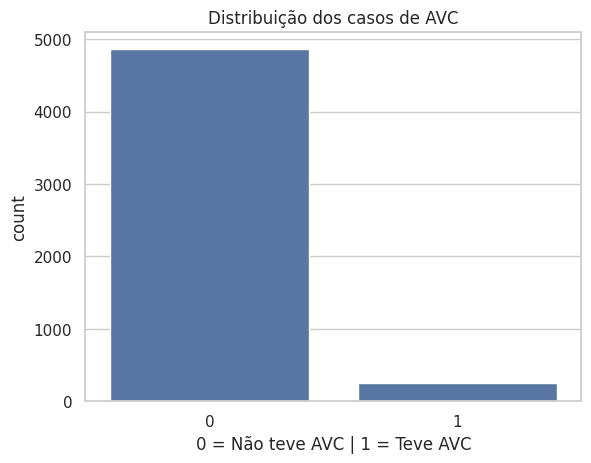

In [37]:
sns.countplot(x='stroke', data=df_stroke)
plt.title("Distribuição dos casos de AVC")
plt.xlabel("0 = Não teve AVC | 1 = Teve AVC")
plt.show()


### 🔹 Qual seria uma baseline accuracy se sempre prevêssemos 'não AVC'?

In [38]:

print("Baseline accuracy (prever sempre 'não AVC'):", (df_stroke['stroke'] == 0).mean())


Baseline accuracy (prever sempre 'não AVC'): 0.9512720156555773


## 7. Comportamento combinado de variáveis

### 🔹 Pacientes com mais de 60 anos, hipertensos e fumantes têm maior probabilidade?

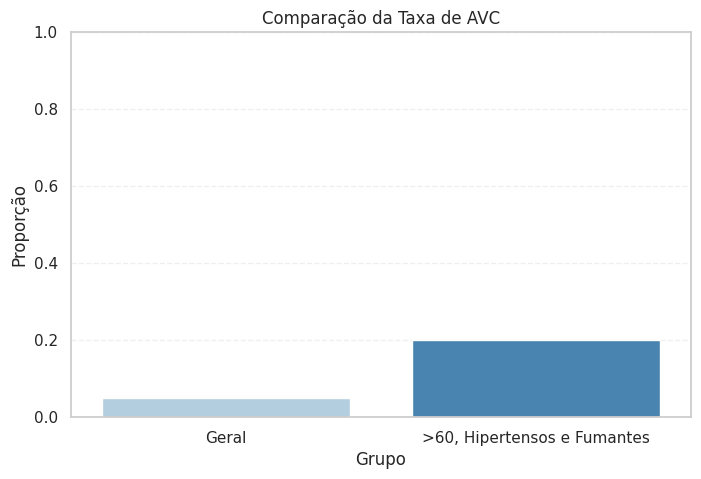

Taxa geral de AVC: 4.87%
Taxa no grupo >60, hipertensos e fumantes: 20.18%


In [39]:
# Filtrar pacientes com mais de 60 anos, hipertensos e fumantes
grupo_risco = df_stroke[
    (df_stroke['age'] > 60) &
    (df_stroke['hypertension'] == 1) &
    (df_stroke['smoking_status'].isin(['formerly smoked', 'smokes']))
]

# Calcular taxas
taxa_grupo = grupo_risco['stroke'].mean()
taxa_geral = df_stroke['stroke'].mean()

# Criar DataFrame para o gráfico
df_taxas = pd.DataFrame({
    'Grupo': ['Geral', '>60, Hipertensos e Fumantes'],
    'Taxa de AVC': [taxa_geral, taxa_grupo]
})

# Plot
plt.figure(figsize=(8,5))
sns.barplot(data=df_taxas, x='Grupo', y='Taxa de AVC', hue='Grupo', legend=False, palette='Blues')
plt.title('Comparação da Taxa de AVC')
plt.ylabel('Proporção')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.show()

# Print no console para reforçar
print(f"Taxa geral de AVC: {taxa_geral:.2%}")
print(f"Taxa no grupo >60, hipertensos e fumantes: {taxa_grupo:.2%}")



### 🔹 Pessoas com IMC acima de 30 e doença cardíaca são mais propensas ao AVC?

              Grupo  Taxa de AVC
0  IMC>30 e Coração     0.186441
1            Outros     0.045473


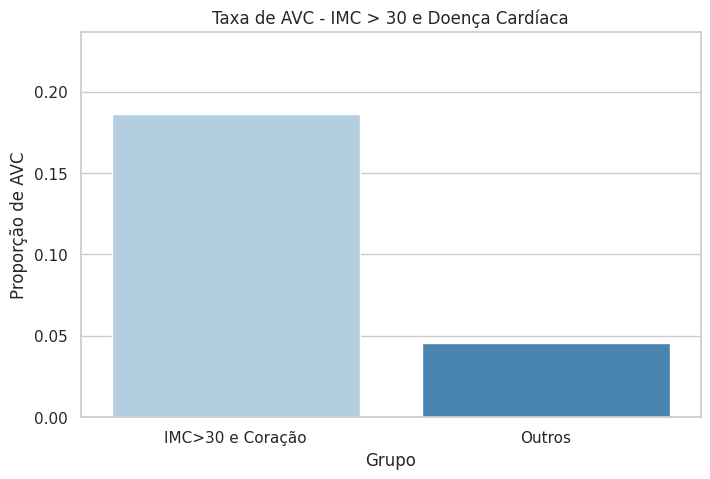

In [40]:
# Criando uma coluna que identifica pacientes com IMC > 30 e doença cardíaca
df_stroke['grupo_risco'] = df_stroke.apply(lambda row:
                             'IMC>30 e Coração' if row['bmi'] > 30 and row['heart_disease'] == 1
                             else 'Outros', axis=1)

# Calculando taxa de AVC por grupo
df_risco = df_stroke.groupby('grupo_risco')['stroke'].mean().reset_index()
df_risco.columns = ['Grupo', 'Taxa de AVC']

# Exibindo a tabela
print(df_risco)

# Gráfico
plt.figure(figsize=(8,5))
sns.barplot(data=df_risco, x='Grupo', y='Taxa de AVC', hue='Grupo', palette='Blues', legend=False)
plt.title("Taxa de AVC - IMC > 30 e Doença Cardíaca")
plt.ylabel("Proporção de AVC")
plt.ylim(0, df_risco['Taxa de AVC'].max() + 0.05)
plt.show()


### 🔹 Existe um grupo de risco claro com base em múltiplas variáveis combinadas?

Total no grupo de risco: 53
Percentual com AVC: 22.64 %


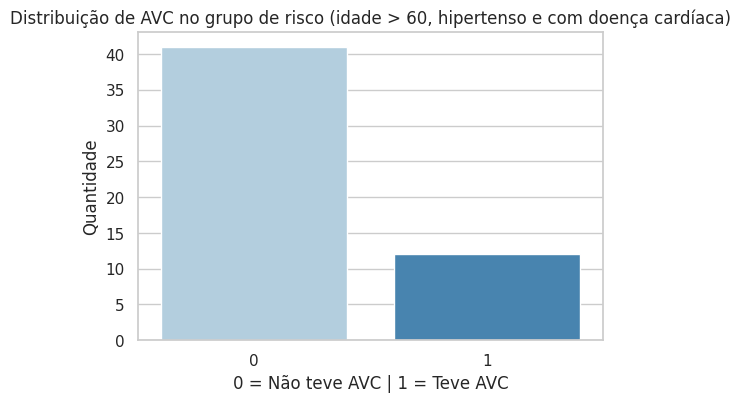

In [41]:
# Filtra grupo de risco
grupo_risco = df_stroke[(df_stroke['age'] > 60) & (df_stroke['hypertension'] == 1) & (df_stroke['heart_disease'] == 1)]

# Exibe estatísticas
print("Total no grupo de risco:", len(grupo_risco))
print("Percentual com AVC:", (grupo_risco['stroke'].mean() * 100).round(2), "%")

# Cria gráfico de barras para visualização
plt.figure(figsize=(6,4))
sns.countplot(data=grupo_risco, x="stroke", hue="stroke", palette="Blues", legend=False)
plt.title("Distribuição de AVC no grupo de risco (idade > 60, hipertenso e com doença cardíaca)")
plt.xlabel("0 = Não teve AVC | 1 = Teve AVC")
plt.ylabel("Quantidade")
plt.show()



## 8. Diagnóstico antecipado e prevenção

### 🔹 Há algum padrão precoce detectável que indicaria risco de AVC?

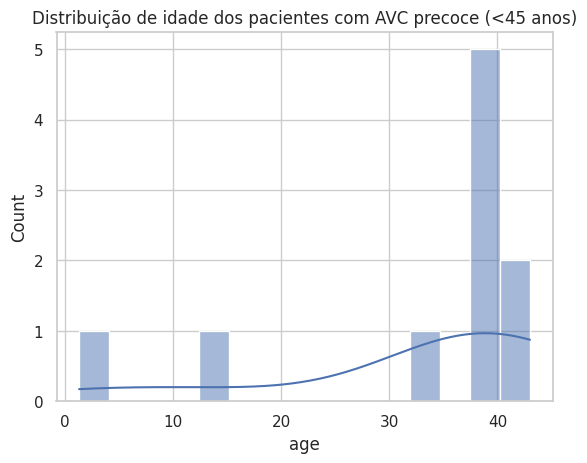

,age,hypertension,heart_disease,avg_glucose_level,bmi
count,10.000000,10.000000,10.0,10.000000,8.000000
mean,32.532000,0.100000,0.0,85.409000,31.400000
std,13.753513,0.316228,0.0,24.963269,7.498571
min,1.320000,0.000000,0.0,57.930000,24.000000
25%,33.500000,0.000000,0.0,71.810000,26.075000
50%,38.500000,0.000000,0.0,82.760000,29.750000
75%,39.000000,0.000000,0.0,94.172500,32.975000
max,43.000000,1.000000,0.0,143.430000,45.900000


In [42]:
sns.histplot(data=df_stroke[(df_stroke['stroke'] == 1) & (df_stroke['age'] < 45)], x='age', bins=15, kde=True)
plt.title("Distribuição de idade dos pacientes com AVC precoce (<45 anos)")
plt.show()

df_precoce = df_stroke[(df_stroke['stroke'] == 1) & (df_stroke['age'] < 45)]
df_precoce[['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi', 'smoking_status']].describe()



### 🔹 Algum subgrupo com baixo risco aparente (ex: jovem, saudável) aparece com AVC?

In [43]:
grupo_baixo_risco = df_stroke[(df_stroke['age'] < 30) & (df_stroke['hypertension'] == 0) & (df_stroke['heart_disease'] == 0)]
print("Total em baixo risco:", len(grupo_baixo_risco))
print("Casos com AVC:", grupo_baixo_risco['stroke'].sum())


Total em baixo risco: 1502
Casos com AVC: 2


# Tratamento dos dados

In [44]:
dfstroke_tratamento = df_stroke.copy()
dfstroke_tratamento.drop('grupo_risco', axis=1, inplace=True)

In [45]:
dfstroke_tratamento.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


###Coluna 'gender'

In [46]:
dfstroke_tratamento['gender'].unique()

array(['Male', 'Female', 'Other'], dtype=object)

In [47]:
dfstroke_tratamento['gender'].value_counts()

,count
gender,
Female,2994
Male,2115
Other,1


In [48]:
dfstroke_tratamento['gender'] = dfstroke_tratamento['gender'].str.lower().str.strip()

In [49]:
dfstroke_tratamento['gender'] = dfstroke_tratamento['gender'].astype('category')

In [50]:
le = LabelEncoder()
dfstroke_tratamento['gender'] = le.fit_transform(dfstroke_tratamento['gender'])

###Coluna 'ever_married' - Converter dados para booleanos

In [51]:
dfstroke_tratamento['ever_married'].nunique()

2

In [52]:
dfstroke_tratamento['ever_married'].unique()

array(['Yes', 'No'], dtype=object)

In [53]:
dfstroke_tratamento['ever_married'].value_counts()

,count
ever_married,
Yes,3353
No,1757


In [54]:
dfstroke_tratamento['ever_married'] = dfstroke_tratamento['ever_married'].str.lower().str.strip()

In [55]:
mapeamento_ever_married = {'yes': True, 'no': False}
dfstroke_tratamento['ever_married'] = dfstroke_tratamento['ever_married'].map(mapeamento_ever_married)

In [56]:
dfstroke_tratamento.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   int64  
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   bool   
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: bool(1), float64(3), int64(5), object(3)
memory usage: 444.3+ KB


###Coluna 'work_type'

In [57]:
dfstroke_tratamento['work_type'].nunique()

5

In [58]:
dfstroke_tratamento['work_type'].value_counts()

,count
work_type,
Private,2925
Self-employed,819
children,687
Govt_job,657
Never_worked,22


In [59]:
dfstroke_tratamento['work_type'] = dfstroke_tratamento['work_type'].str.strip().str.lower()

In [60]:
worktype_encoded = pd.get_dummies(dfstroke_tratamento['work_type'], prefix='worktype')

In [61]:
dfstroke_concatenado = pd.concat([dfstroke_tratamento, worktype_encoded], axis=1)

In [62]:
dfstroke_concatenado.drop('work_type', axis=1, inplace=True)

In [63]:
dfstroke_concatenado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      5110 non-null   int64  
 1   gender                  5110 non-null   int64  
 2   age                     5110 non-null   float64
 3   hypertension            5110 non-null   int64  
 4   heart_disease           5110 non-null   int64  
 5   ever_married            5110 non-null   bool   
 6   Residence_type          5110 non-null   object 
 7   avg_glucose_level       5110 non-null   float64
 8   bmi                     4909 non-null   float64
 9   smoking_status          5110 non-null   object 
 10  stroke                  5110 non-null   int64  
 11  worktype_children       5110 non-null   bool   
 12  worktype_govt_job       5110 non-null   bool   
 13  worktype_never_worked   5110 non-null   bool   
 14  worktype_private        5110 non-null   

###Coluna 'Residence_type'

In [64]:
dfstroke_concatenado['Residence_type'].value_counts()

,count
Residence_type,
Urban,2596
Rural,2514


In [65]:
dfstroke_concatenado['Residence_type'] = dfstroke_concatenado['Residence_type'].str.lower().str.strip()

In [66]:
residence_type_encoded = pd.get_dummies(dfstroke_concatenado['Residence_type'], prefix='Localizacao', drop_first=True)

In [67]:
residence_type_encoded

,Localizacao_urban
0,True
1,False
2,False
3,True
4,False
...,...
5105,True
5106,True
5107,False
5108,False


In [68]:
dfstroke_concatenado['Residence_type'].head()

,Residence_type
0,urban
1,rural
2,rural
3,urban
4,rural


In [69]:
dfstroke_concatenado = pd.concat([dfstroke_concatenado, residence_type_encoded], axis=1)
dfstroke_concatenado.drop('Residence_type', axis=1, inplace=True)

In [70]:
dfstroke_concatenado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      5110 non-null   int64  
 1   gender                  5110 non-null   int64  
 2   age                     5110 non-null   float64
 3   hypertension            5110 non-null   int64  
 4   heart_disease           5110 non-null   int64  
 5   ever_married            5110 non-null   bool   
 6   avg_glucose_level       5110 non-null   float64
 7   bmi                     4909 non-null   float64
 8   smoking_status          5110 non-null   object 
 9   stroke                  5110 non-null   int64  
 10  worktype_children       5110 non-null   bool   
 11  worktype_govt_job       5110 non-null   bool   
 12  worktype_never_worked   5110 non-null   bool   
 13  worktype_private        5110 non-null   bool   
 14  worktype_self-employed  5110 non-null   

###Coluna 'smoking_status'

In [71]:
dfstroke_concatenado['smoking_status'].value_counts()

,count
smoking_status,
never smoked,1892
Unknown,1544
formerly smoked,885
smokes,789


In [72]:
dfstroke_concatenado['smoking_status'] = dfstroke_concatenado['smoking_status'].str.lower().str.strip()

In [73]:
dfstroke_concatenado['smoking_status'].unique()

array(['formerly smoked', 'never smoked', 'smokes', 'unknown'],
      dtype=object)

In [74]:
from sklearn.preprocessing import OrdinalEncoder
df_stroke_tratado = dfstroke_concatenado.copy()
df_stroke_tratado['smoking_status'] = OrdinalEncoder(categories=[['never smoked', 'formerly smoked', 'smokes', 'unknown']]).fit_transform(dfstroke_concatenado[['smoking_status']])

In [75]:
df_stroke_tratado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      5110 non-null   int64  
 1   gender                  5110 non-null   int64  
 2   age                     5110 non-null   float64
 3   hypertension            5110 non-null   int64  
 4   heart_disease           5110 non-null   int64  
 5   ever_married            5110 non-null   bool   
 6   avg_glucose_level       5110 non-null   float64
 7   bmi                     4909 non-null   float64
 8   smoking_status          5110 non-null   float64
 9   stroke                  5110 non-null   int64  
 10  worktype_children       5110 non-null   bool   
 11  worktype_govt_job       5110 non-null   bool   
 12  worktype_never_worked   5110 non-null   bool   
 13  worktype_private        5110 non-null   bool   
 14  worktype_self-employed  5110 non-null   

###Tratar Valores nulos

In [76]:
df_stroke_tratado.isnull().sum()

,0
id,0
gender,0
age,0
hypertension,0
heart_disease,0
ever_married,0
avg_glucose_level,0
bmi,201
smoking_status,0
stroke,0


In [77]:
dfstroke_tratado = df_stroke_tratado.copy()
dfstroke_tratado['bmi'] = dfstroke_tratado['bmi'].fillna(dfstroke_tratado['bmi'].median())

###Conversão de todos os dados booleanos para 0 e 1

In [78]:
for coluna in dfstroke_tratado.select_dtypes(include='bool').columns:
    dfstroke_tratado[coluna] = dfstroke_tratado[coluna].astype(int)

In [79]:
dfstroke_tratado.head()

,id,gender,age,hypertension,heart_disease,ever_married,avg_glucose_level,bmi,smoking_status,stroke,worktype_children,worktype_govt_job,worktype_never_worked,worktype_private,worktype_self-employed,Localizacao_urban
0,9046,1,67.0,0,1,1,228.69,36.6,1.0,1,0,0,0,1,0,1
1,51676,0,61.0,0,0,1,202.21,28.1,0.0,1,0,0,0,0,1,0
2,31112,1,80.0,0,1,1,105.92,32.5,0.0,1,0,0,0,1,0,0
3,60182,0,49.0,0,0,1,171.23,34.4,2.0,1,0,0,0,1,0,1
4,1665,0,79.0,1,0,1,174.12,24.0,0.0,1,0,0,0,0,1,0


In [80]:
dfstroke_tratado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      5110 non-null   int64  
 1   gender                  5110 non-null   int64  
 2   age                     5110 non-null   float64
 3   hypertension            5110 non-null   int64  
 4   heart_disease           5110 non-null   int64  
 5   ever_married            5110 non-null   int64  
 6   avg_glucose_level       5110 non-null   float64
 7   bmi                     5110 non-null   float64
 8   smoking_status          5110 non-null   float64
 9   stroke                  5110 non-null   int64  
 10  worktype_children       5110 non-null   int64  
 11  worktype_govt_job       5110 non-null   int64  
 12  worktype_never_worked   5110 non-null   int64  
 13  worktype_private        5110 non-null   int64  
 14  worktype_self-employed  5110 non-null   

#Correlação

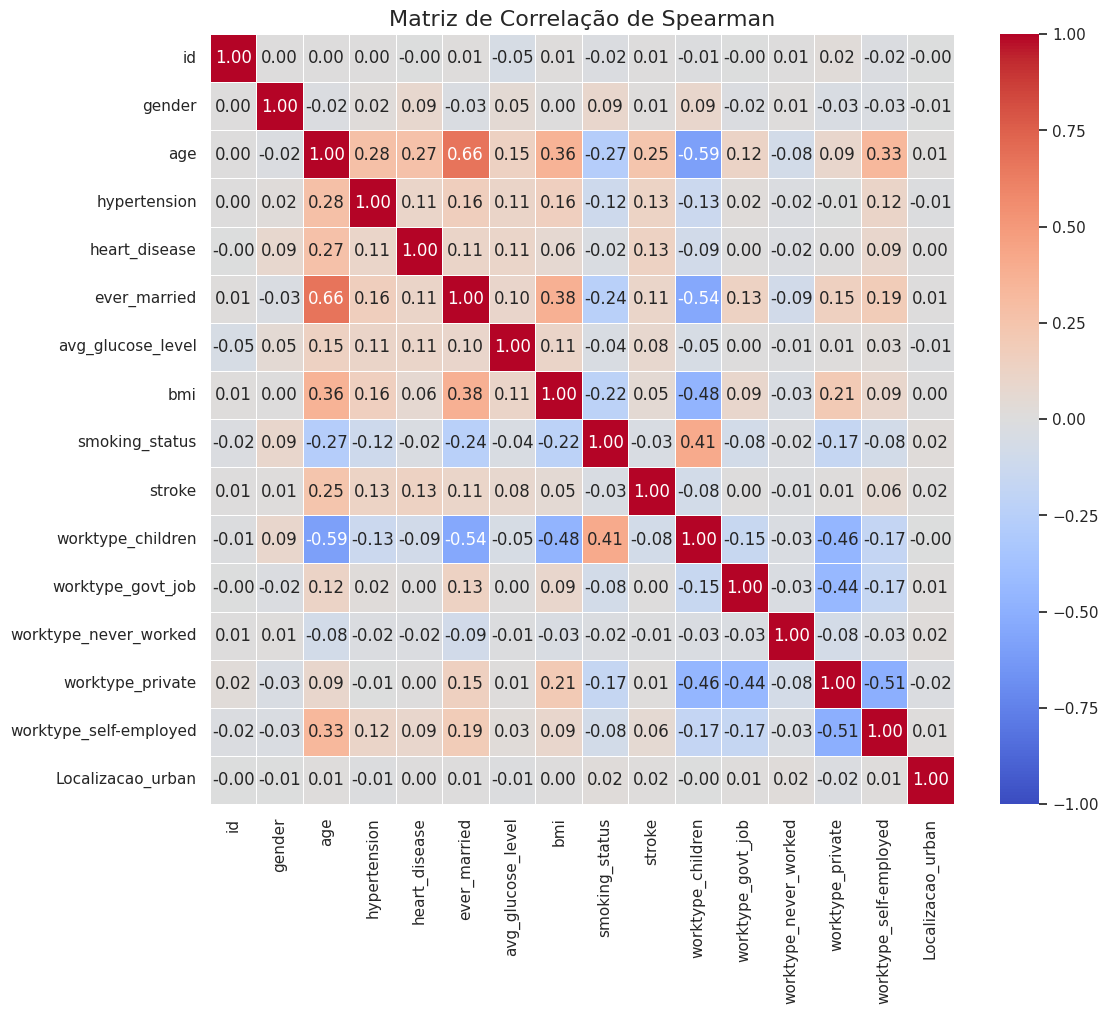

In [81]:
# Correlação de Spearman
spearman_corr_matrix = dfstroke_tratado.corr(method='spearman')

plt.figure(figsize=(12, 10))
sns.heatmap(
    spearman_corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    linewidths=.5,
    vmin=-1, vmax=1)

plt.title('Matriz de Correlação de Spearman', fontsize=16)

plt.show()

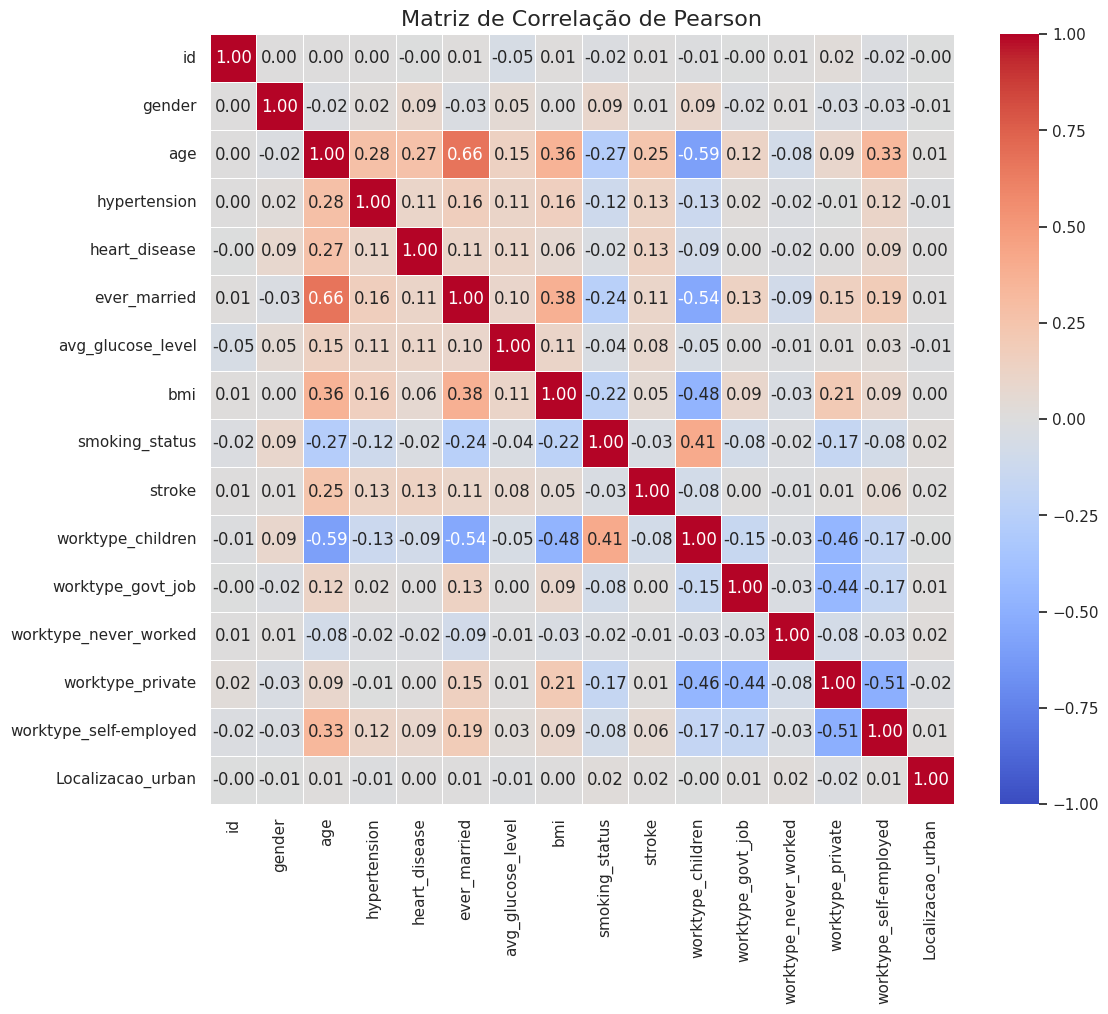

In [82]:
#Matriz de Correção de Pearson
pearson_corr_matrix = dfstroke_tratado.corr(method='pearson')

plt.figure(figsize=(12, 10))
sns.heatmap(
    spearman_corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    linewidths=.5,
    vmin=-1, vmax=1)

plt.title('Matriz de Correlação de Pearson', fontsize=16)

plt.show()

#Construção dos modelos

##Separação dos dados de treino e teste e escalonamento dos dados

In [83]:
#Separação da base de treino e de teste
x = dfstroke_tratado[['gender','age','hypertension','heart_disease','ever_married','avg_glucose_level','bmi','smoking_status','worktype_children','worktype_govt_job','worktype_never_worked','worktype_private','worktype_self-employed','Localizacao_urban']]
y = dfstroke_tratado['stroke']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)


In [84]:
x_train.shape

(4088, 14)

In [85]:
x_test.shape

(1022, 14)

In [86]:
# Escalonamento dos dados
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(x_train)

x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

##Randon Forest

In [87]:
rf = RandomForestClassifier(n_estimators=5, max_depth = 2,  random_state=7)

rf.fit(x_train_scaled, y_train)

RandomForestClassifier(max_depth=2, n_estimators=5, random_state=7)

In [88]:
estimator = rf.estimators_
y_pred_rf = rf.predict(x_test_scaled)

In [89]:
acuracia = accuracy_score(y_test, y_pred_rf)
print("Acurácia:", acuracia)

Acurácia: 0.9510763209393346


In [90]:
print (rf.score(x_train_scaled, y_train))
print(rf.score(x_test_scaled, y_test))

0.951320939334638
0.9510763209393346


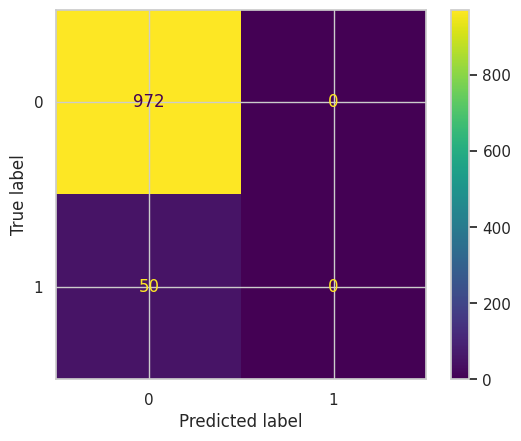

In [91]:
cm = confusion_matrix(y_test, y_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [92]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97       972
           1       0.00      0.00      0.00        50

    accuracy                           0.95      1022
   macro avg       0.48      0.50      0.49      1022
weighted avg       0.90      0.95      0.93      1022



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


##SVM

Acurácia: 0.9510763209393346


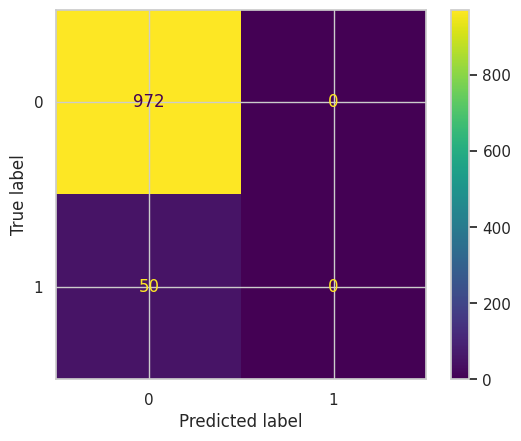

In [93]:
svm_model = Pipeline(
    [
        ("linear_svc", LinearSVC(C=1, loss="hinge", random_state=42)),
    ]
)
svm_model.fit(x_train_scaled, y_train)
y_pred_svm = svm_model.predict(x_test_scaled)

acuracia = accuracy_score(y_test, y_pred_svm)
print("Acurácia:", acuracia)

cm = confusion_matrix(y_test, y_pred_svm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [94]:
print(classification_report(y_test, y_pred_rf))

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.95      1.00      0.97       972
           1       0.00      0.00      0.00        50

    accuracy                           0.95      1022
   macro avg       0.48      0.50      0.49      1022
weighted avg       0.90      0.95      0.93      1022



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


##KNN

Text(0, 0.5, 'Mean Error')

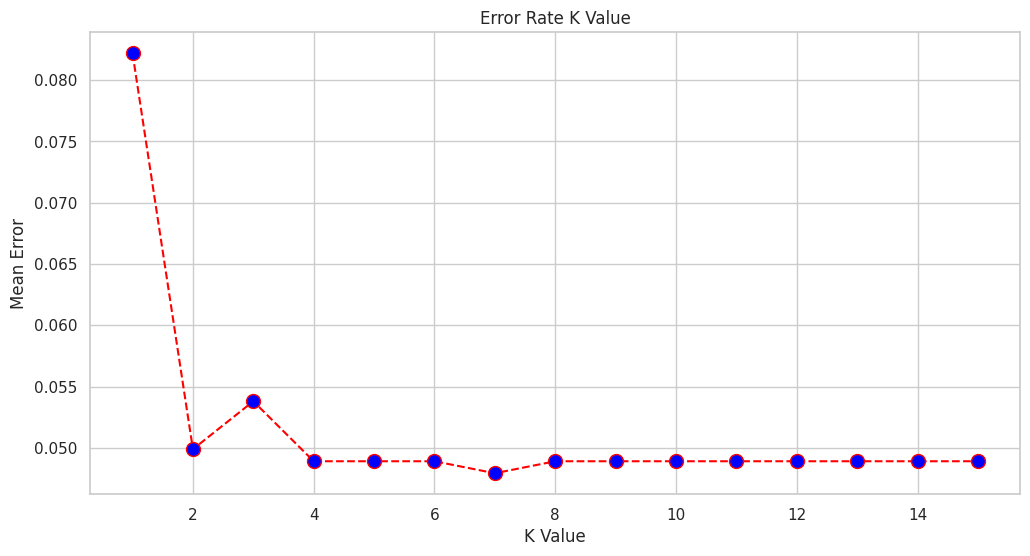

In [95]:
error = []

for i in range(1, 16):
  knn = KNeighborsClassifier(n_neighbors=i)
  knn.fit(x_train_scaled, y_train)
  pred_i = knn.predict(x_test_scaled)
  error.append(np.mean(pred_i != y_test))


plt.figure(figsize=(12, 6))
plt.plot(range(1, 16), error, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)

plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')

Acurácia: 0.9510763209393346


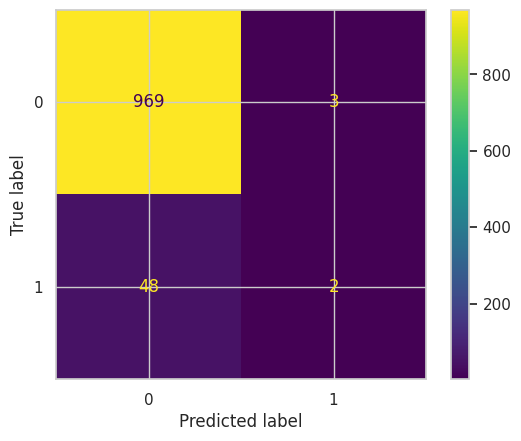

In [96]:
modelo_classificaor_knn = KNeighborsClassifier(n_neighbors=2)
modelo_classificaor_knn.fit(x_train_scaled, y_train)
y_pred_knn = modelo_classificaor_knn.predict(x_test_scaled)

acuracia = accuracy_score(y_test, y_pred_svm)
print("Acurácia:", acuracia)

cm = confusion_matrix(y_test, y_pred_knn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

Acurácia: 0.9510763209393346


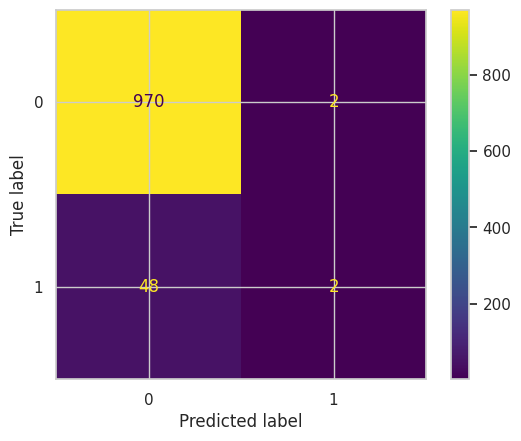

In [97]:
modelo_classificaor_knn = KNeighborsClassifier(n_neighbors=4)
modelo_classificaor_knn.fit(x_train_scaled, y_train)
y_pred_knn = modelo_classificaor_knn.predict(x_test_scaled)

acuracia = accuracy_score(y_test, y_pred_svm)
print("Acurácia:", acuracia)


cm = confusion_matrix(y_test, y_pred_knn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

Acurácia: 0.9510763209393346


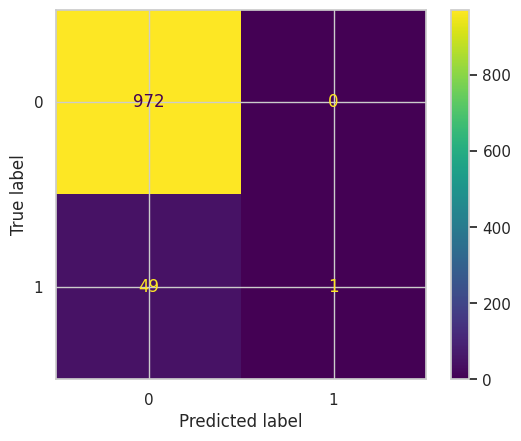

In [98]:
modelo_classificaor_knn = KNeighborsClassifier(n_neighbors=7)
modelo_classificaor_knn.fit(x_train_scaled, y_train)
y_pred_knn = modelo_classificaor_knn.predict(x_test_scaled)

acuracia = accuracy_score(y_test, y_pred_svm)
print("Acurácia:", acuracia)


cm = confusion_matrix(y_test, y_pred_knn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

##Análise do Resultado

Os modelos não estão performando satisfatoriamente pois embora a acurácia esteja alta o numero de falsos negativos também está muito alto, apenas o modelo usando o KNN conseguiu identificar algum caso positivo de AVC.

Possíveis causas para esse resultado:
 - Isso pode estar ocorrendo pois o número de amostras com o valor 'stroke' = 0 é muito maior do que os que tem 'stroke' = 1

In [99]:
# Distribuição dos valores da variável target
df_stroke['stroke'].value_counts()

,count
stroke,
0,4861
1,249


#Construção de Modelos com aplicação de ajuste de pesos e undersampling

Acurácia: 0.6418786692759295


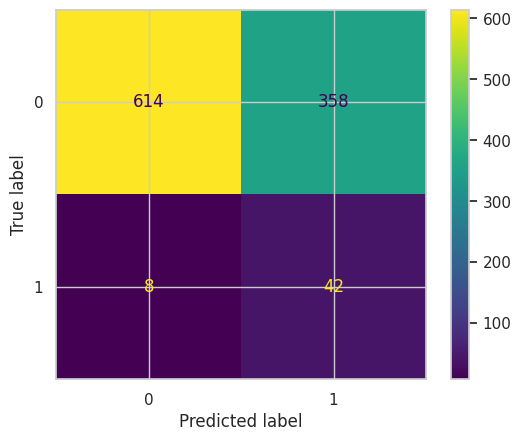

In [100]:
#Ajuste dos pesos (class_weight)
rf_model = RandomForestClassifier(n_estimators=5, max_depth = 2, class_weight='balanced',  random_state=7)
rf_model.fit(x_train_scaled, y_train)

y_pred_rf_2 = rf_model.predict(x_test_scaled)


acuracia = accuracy_score(y_test, y_pred_rf_2)
print("Acurácia:", acuracia)

cm = confusion_matrix(y_test, y_pred_rf_2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [101]:
#Aplicando o undersampling

rus = RandomUnderSampler(random_state=42)
x_res, y_res = rus.fit_resample(x_train_scaled, y_train)

print("Distribuição das classes após undersampling:")
print(y_res.value_counts())

Distribuição das classes após undersampling:
stroke
0    199
1    199
Name: count, dtype: int64


Acurácia: 0.6056751467710372


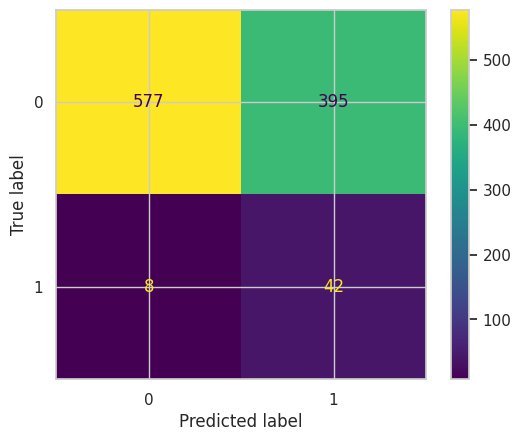

In [102]:
#RandomForest com undersampling

rf_model_u = RandomForestClassifier(n_estimators=6, max_depth = 2, class_weight='balanced',  random_state=7)
rf_model_u.fit(x_res, y_res)

y_pred_rf_u = rf_model_u.predict(x_test_scaled)


acuracia = accuracy_score(y_test, y_pred_rf_u)
print("Acurácia:", acuracia)

cm = confusion_matrix(y_test, y_pred_rf_u)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [103]:
# Validação cruzada
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
result = cross_val_score(rf_model_u, x_res, y_res, cv=kfold)
print(result)
print(result.mean())

[0.65       0.775      0.825      0.8        0.775      0.75
 0.65       0.75       0.82051282 0.82051282]
0.761602564102564


In [112]:
print(classification_report(y_test, y_pred_rf_u))

              precision    recall  f1-score   support

           0       0.99      0.68      0.80       972
           1       0.12      0.84      0.21        50

    accuracy                           0.69      1022
   macro avg       0.55      0.76      0.51      1022
weighted avg       0.95      0.69      0.77      1022



In [104]:
#Usando o Grid Search para encontrar melhores hiperparâmetros

param_grid = {
    'n_estimators': [5, 10, 15, 20, 25, 30],  # Valores para testar
    'max_depth': [5, 10, None],                    # Outros hiperparâmetros importantes
    'min_samples_split': [2, 5, 10]
}

gs_metric = make_scorer(accuracy_score, greater_is_better=True)

grid_search = GridSearchCV(RandomForestClassifier(),
                    param_grid=param_grid,
                    scoring=gs_metric,
                    cv=5, n_jobs=4, verbose=3)

grid_search.fit(x_res, y_res)


print(f"Melhores hiperparâmetros: {grid_search.best_params_}")
print(f"Melhor pontuação (F1-Score): {grid_search.best_score_:.4f}")

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Melhores hiperparâmetros: {'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 25}
Melhor pontuação (F1-Score): 0.7690


Acurácia: 0.6800391389432485


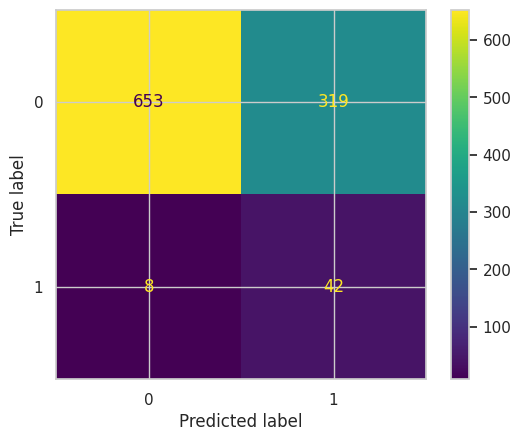

In [113]:
#RandomForest com undersampling e melhores hiperparâmetros encontrados no grid search

rf_model_u_b = RandomForestClassifier(n_estimators=25, max_depth=5, min_samples_split=5)
rf_model_u_b.fit(x_res, y_res)

y_pred_rf_u_b = rf_model_u_b.predict(x_test_scaled)


acuracia = accuracy_score(y_test, y_pred_rf_u_b)
print("Acurácia:", acuracia)

cm = confusion_matrix(y_test, y_pred_rf_u_b)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [114]:
print(classification_report(y_test, y_pred_rf_u_b))

              precision    recall  f1-score   support

           0       0.99      0.67      0.80       972
           1       0.12      0.84      0.20        50

    accuracy                           0.68      1022
   macro avg       0.55      0.76      0.50      1022
weighted avg       0.95      0.68      0.77      1022



/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Acurácia: 0.713307240704501


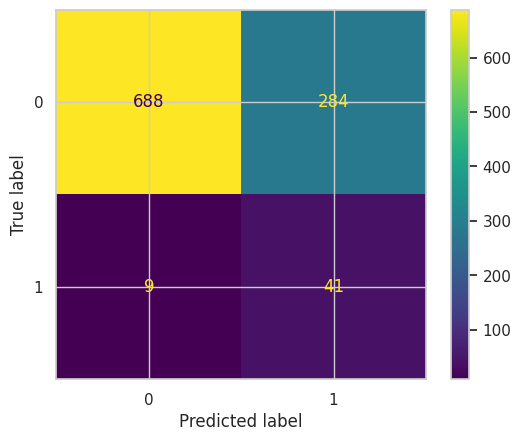

In [106]:
#SVM com undersampling

svm_model = Pipeline(
    [
        ("linear_svc", LinearSVC(C=1, loss="hinge", random_state=42)),
    ]
)
svm_model.fit(x_res, y_res)
y_pred_svm_u = svm_model.predict(x_test_scaled)

acuracia = accuracy_score(y_test, y_pred_svm_u)
print("Acurácia:", acuracia)

cm = confusion_matrix(y_test, y_pred_svm_u)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [115]:
print(classification_report(y_test, y_pred_svm_u))

              precision    recall  f1-score   support

           0       0.99      0.71      0.82       972
           1       0.13      0.82      0.22        50

    accuracy                           0.71      1022
   macro avg       0.56      0.76      0.52      1022
weighted avg       0.94      0.71      0.79      1022



Text(0, 0.5, 'Mean Error')

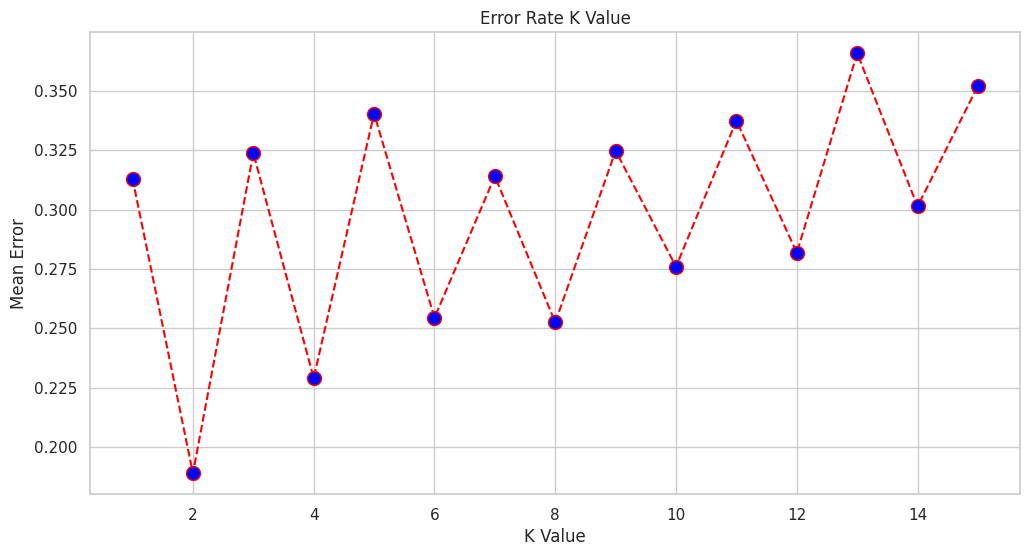

In [107]:
# KNN com undersampling

error_u = []

for i in range(1, 16):
  knn_u = KNeighborsClassifier(n_neighbors=i)
  knn_u.fit(x_res, y_res)
  pred_i_u = knn_u.predict(x_test_scaled)
  error_u.append(np.mean(pred_i_u != y_test))


plt.figure(figsize=(12, 6))
plt.plot(range(1, 16), error_u, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)

plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')

Acurácia: 0.8111545988258317


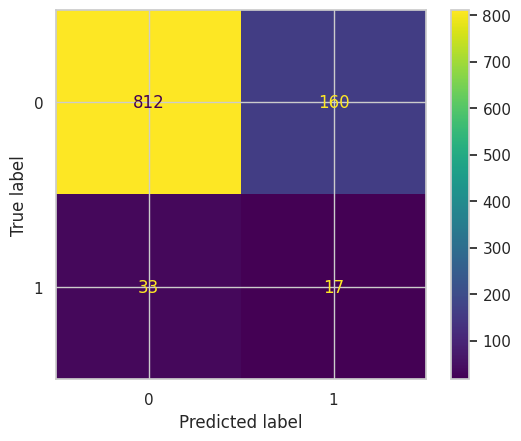

In [108]:
# KNN com undersampling

modelo_classificaor_knn_u = KNeighborsClassifier(n_neighbors=2)
modelo_classificaor_knn_u.fit(x_res, y_res)
y_pred_knn_u = modelo_classificaor_knn_u.predict(x_test_scaled)

acuracia = accuracy_score(y_test, y_pred_knn_u)
print("Acurácia:", acuracia)

cm = confusion_matrix(y_test, y_pred_knn_u)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [116]:
print(classification_report(y_test, y_pred_knn_u))

              precision    recall  f1-score   support

           0       0.96      0.84      0.89       972
           1       0.10      0.34      0.15        50

    accuracy                           0.81      1022
   macro avg       0.53      0.59      0.52      1022
weighted avg       0.92      0.81      0.86      1022



##Análise do Resultado

Após a aplicação do undersampling o número de falsos negativos caiu, porém a acurácia diminiu e os falsos positivos aumentaram.
Obs.: Mais informações no relatório